# Momentum and Contrarian strategies

Today we try two new trading strategies: momentum and contrarian. They act in the same way but are one the inverse of the other. The momentum strategy, see how the price of the last window's time is going: if the price is going up, then we take a long trading position, otherwise if the price is going down we take a short position.
Contrarily with the contrarian strategy, if the price is going up, we think it will go down so we take a short position. Instead if the price is going down we take a long position.

We take the moving average of the last n days (or minutes/hours) do decide if the price is going up or down and, like the previous strategies, the window size is an hyperparameter that we must chose.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

In [11]:
ticker = 'EURUSD=X'
start = '2021-10-10'
end = '2023-10-10'
interval = '1d'
df = yf.download(ticker, start=start, end=end, interval=interval)['Adj Close'].to_frame()

[*********************100%%**********************]  1 of 1 completed


In [12]:
df['logRet'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.dropna(inplace=True)

In [13]:
# For the momentum (and contratian) strategy is better to have a short window
window = 3
# If the moving average is positive we follow the momentum and we go long, otherwise we go short
df['position'] = np.where(df.logRet.rolling(window).mean()>0, 1, -1)

In [14]:
df['momentum'] = df.position.shift(1)*df.logRet
df['contrarian'] = -df.position.shift(1)*df.logRet

In [15]:
# We compare the strategies: buy&hold, momentum, contrarian
df[['logRet','momentum', 'contrarian']].sum()

logRet       -0.090293
momentum     -0.187957
contrarian    0.187957
dtype: float64

<Axes: xlabel='Date'>

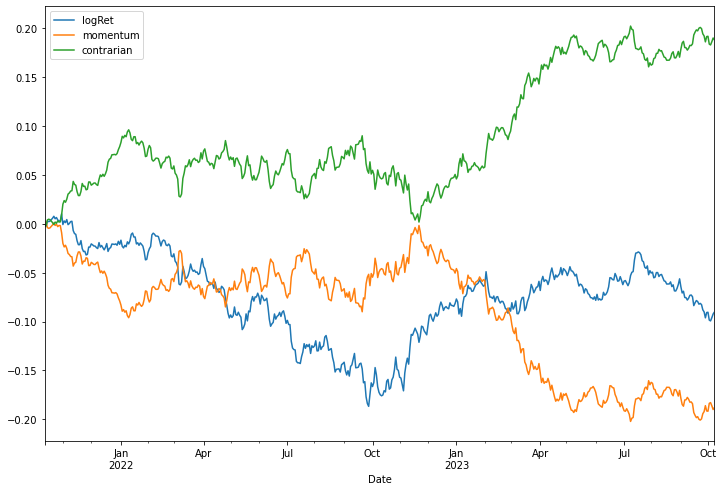

In [16]:
df[['logRet','momentum', 'contrarian']].cumsum().plot(figsize=(12,8))

# Optimize the strategy

Now we want to optimize the strategy, finding the best window value.

In [17]:
strategy = ['logRet']
for w in range(1,16):
    # Append some label to the list, it used just for the plot
    strategy.append('momentum_'+str(w))
    strategy.append('contrarian_'+str(w))
    
    # Trading position given the window w
    df['position_'+str(w)] = np.where(df.logRet.rolling(w).mean()>=0, 1, -1)
    
    # Momentum return given the new position
    df['momentum_'+str(w)] = df['position_'+str(w)].shift(1)*df.logRet
    # Momentum return given the new position
    df['contrarian_'+str(w)] = -df['position_'+str(w)].shift(1)*df.logRet

In [33]:
# We can check the final percentage performance of all the trading strategies
df[strategy].sum()*100

logRet           -9.029265
momentum_1       13.725148
contrarian_1    -13.725148
momentum_2       -4.359749
contrarian_2      4.359749
momentum_3      -18.795703
contrarian_3     18.795703
momentum_4       -9.229929
contrarian_4      9.229929
momentum_5       -6.938160
contrarian_5      6.938160
momentum_6      -13.574346
contrarian_6     13.574346
momentum_7      -21.172427
contrarian_7     21.172427
momentum_8       -3.793964
contrarian_8      3.793964
momentum_9        2.191543
contrarian_9     -2.191543
momentum_10      -6.459009
contrarian_10     6.459009
momentum_11       3.892903
contrarian_11    -3.892903
momentum_12       1.203226
contrarian_12    -1.203226
momentum_13       3.841339
contrarian_13    -3.841339
momentum_14      12.818424
contrarian_14   -12.818424
momentum_15       0.764058
contrarian_15    -0.764058
dtype: float64

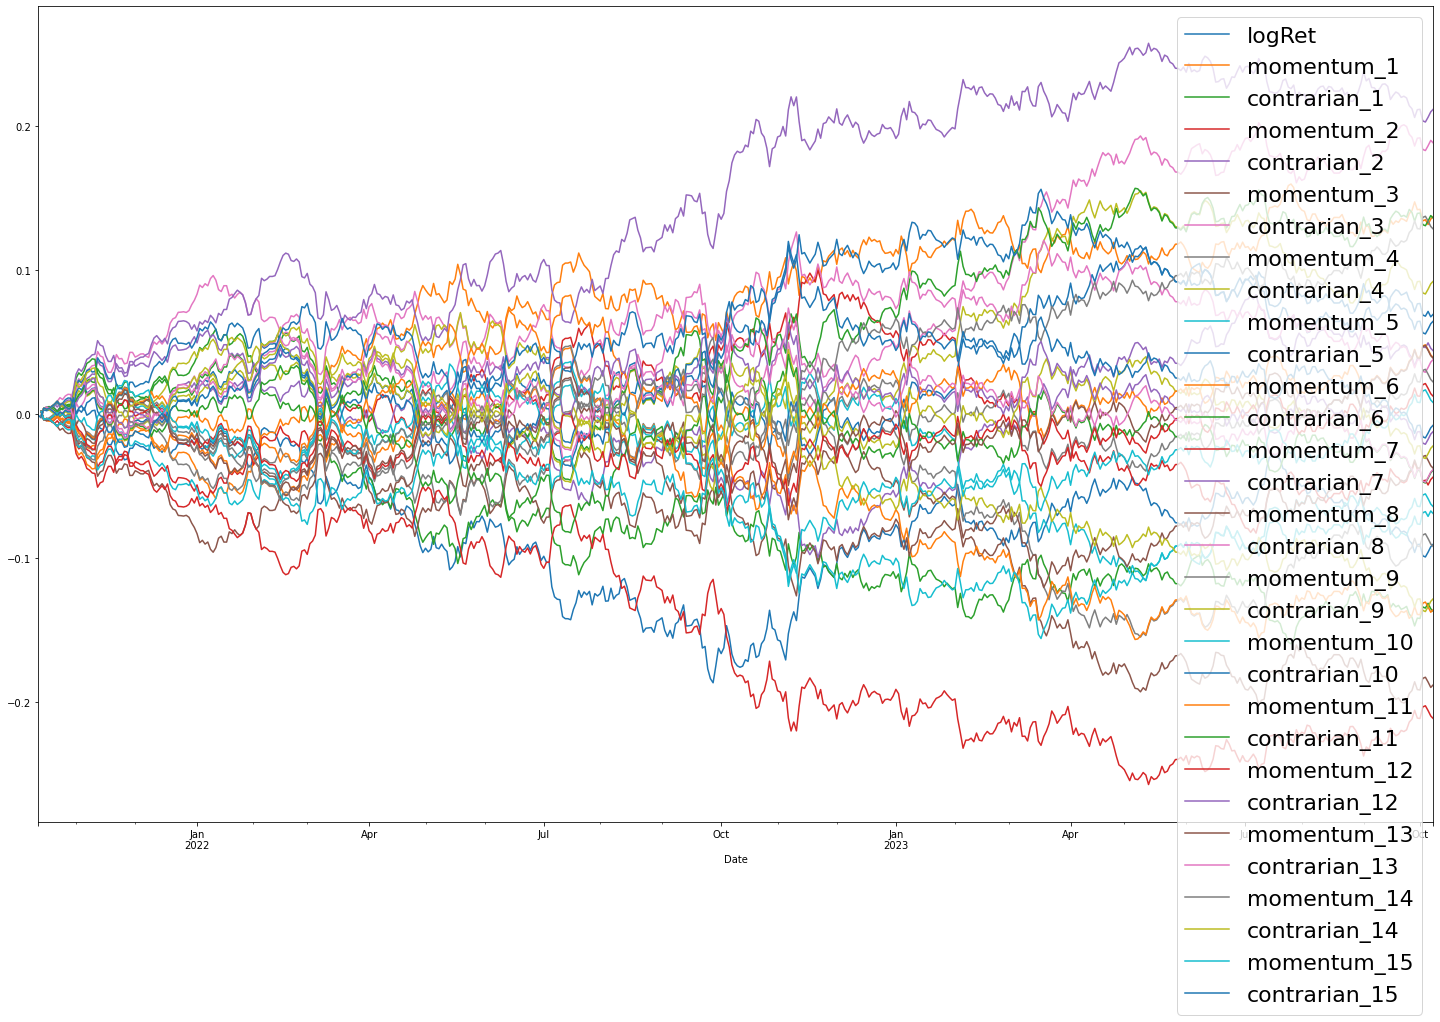

In [19]:
df[strategy].cumsum().plot(figsize=(25,15))
plt.legend(fontsize=22)

# Big problem: trading costs

We have a big problem: these strategies do not consider trading costs. There costs are the one that kill our possible gains. There can be 2 costs linked to the trading:
1. The commission taken by the broker. This is a percentage, with a min and max value, of the value acquired by the client.
2. We would like to buy at the ask price and sell at bid price. We always considered the bid price, but unfortunately the reality is different: for each transaction we lose half spread. The spead is the difference between the ask and bid price. Moreover, in a strategy like this one where we can change from long to short position (or the inverse), basically we're doing 2 transaction (end the long position, open a short position) so we're losing the whole spread.

How we compute them:
1. For the broker commission, we set a percentage (no min or max). In this way we're making the gain computation dependant on how much we invest. We set it with the *comm* variable name.
2. For the spread related cost, in this example where we're trading EUR-USD we know that the average spread is 0.00008 and we divide this value with the average EUR price in USD, so we get a percentage costs.

In [34]:
comm = 0.0
# spread of buying euro with dollars
spread = 0.00008/df['Adj Close'].mean() # price of one euro written in dollars

In [35]:
# Let's see the percentage of spread (it's quite low)
spread*100

0.007442491698936781

The costs we mentioned before are present each time we do a transaction. We can see if the position of two consecutive days is different, it means that we changed our position and we paid the costs:

In [36]:
# If the position of two consecutive days change, it means we paid 2 times the half spread
# otherwise we paid nothing (because we didn't change the postion)
df['transactions'] = np.where(df.position.shift(1)!=df.position.shift(2), 2, 0)

In [37]:
# Percentage we have to pay for the transactions.
df.transactions.sum()*(spread/2+comm)

0.011833561801309482

In [27]:
# We do the same optimization strategy as before
comm_strategy = []

for w in range(1,16):
    # Add the labels to the list
    comm_strategy.append('comm_momentum_'+str(w))
    comm_strategy.append('comm_contrarian_'+str(w))
    
    # Trading position given the window w
    df['position_'+str(w)] = np.where(df.logRet.rolling(w).mean()>=0, 1, -1)
    
    # Momentum return given the new position
    df['momentum_'+str(w)] = df['position_'+str(w)].shift(1)*df.logRet
    # Momentum return given the new position
    df['contrarian_'+str(w)] = -df['position_'+str(w)].shift(1)*df.logRet
    
    # Compute the transactions for this strategy
    df['transactions_'+str(w)] = np.where(df['position_'+str(w)].shift(1) != df['position_'+str(w)].shift(2), 2, 0)
    
    # Momentum with transaction costs
    df['comm_momentum_'+str(w)] = df['momentum_'+str(w)].cumsum() - df['transactions_'+str(w)].cumsum()*(spread/2+comm)
    # Momentum with transaction costs
    df['comm_contrarian_'+str(w)] = df['contrarian_'+str(w)].cumsum() - df['transactions_'+str(w)].cumsum()*(spread/2+comm)
    

<ipython-input-27-417e850cfc16>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['comm_momentum_'+str(w)] = df['momentum_'+str(w)].cumsum() - df['transactions_'+str(w)].cumsum()*(spread/2+comm)
<ipython-input-27-417e850cfc16>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['comm_contrarian_'+str(w)] = df['contrarian_'+str(w)].cumsum() - df['transactions_'+str(w)].cumsum()*(spread/2+comm)
<ipython-input-27-417e850cfc16>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

<Axes: xlabel='Date'>

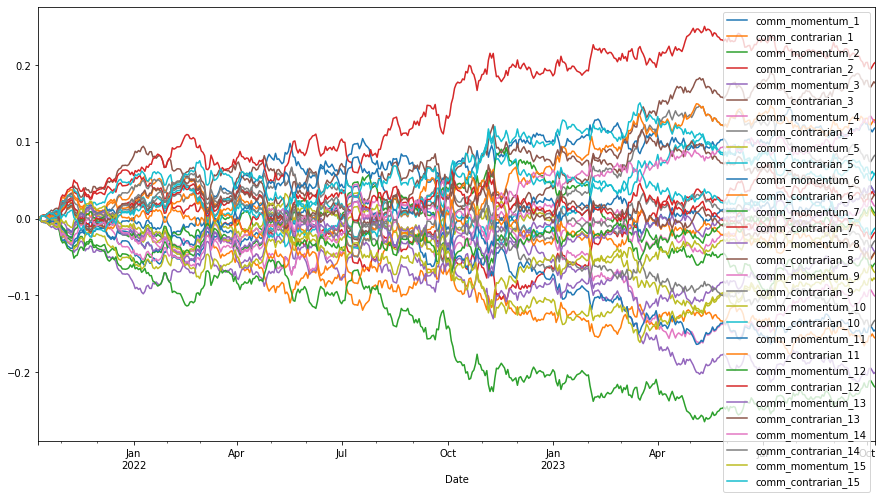

In [28]:
# Plot of returns with spread costs
df[comm_strategy].plot(figsize=(15,8))

<Axes: xlabel='Date'>

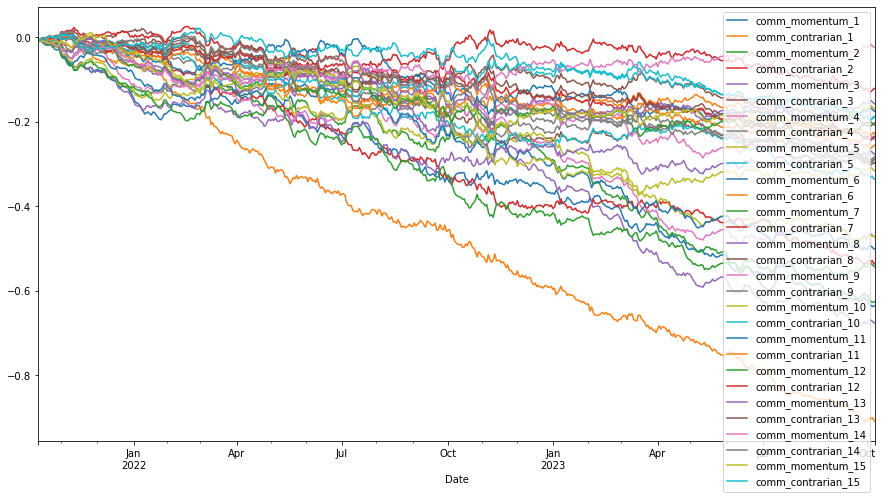

In [32]:
# Finally we can add a commition of 0.15%
comm = 0.0015

# We do the same optimization strategy as before
comm_strategy = []

for w in range(1,16):
    comm_strategy.append('comm_momentum_'+str(w))
    comm_strategy.append('comm_contrarian_'+str(w))
    # Trading position given the window w
    df['position_'+str(w)] = np.where(df.logRet.rolling(w).mean()>=0, 1, -1)
    
    # Momentum return given the new position
    df['momentum_'+str(w)] = df['position_'+str(w)].shift(1)*df.logRet
    # Momentum return given the new position
    df['contrarian_'+str(w)] = -df['position_'+str(w)].shift(1)*df.logRet
    
    # Compute the transactions for this strategy
    df['transactions_'+str(w)] = np.where(df['position_'+str(w)].shift(1) != df['position_'+str(w)].shift(2), 2, 0)
    
    # Momentum with transaction costs
    df['comm_momentum_'+str(w)] = df['momentum_'+str(w)].cumsum() - df['transactions_'+str(w)].cumsum()*(spread/2+comm)
    # Momentum with transaction costs
    df['comm_contrarian_'+str(w)] = df['contrarian_'+str(w)].cumsum() - df['transactions_'+str(w)].cumsum()*(spread/2+comm)


# Plot of returns with broker and spread costs
df[comm_strategy].plot(figsize=(15,8))

We can see that with the commission of the broker, all the gains are killed by the costs!